- Load dataset from tensorflow
- Print total number of images in dataset

In [133]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Construct a tf.data.Dataset
ds = tfds.load('tf_flowers', split='train', shuffle_files=True, as_supervised=True)
# as_supervised will return tuple (image, label)
# to get info:
ds_info = tfds.builder('tf_flowers').info

# Get class names and total images
class_names = ds_info.features['label'].names
num_images = ds_info.splits['train'].num_examples

print("Classes:", class_names)
print("Total images:", num_images)

Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Total images: 3670


Print total number of images of each class in dataset

In [134]:
# prompt: Total images of each classes in ds

from collections import Counter

# Create a counter to store the number of images per class
image_counts = Counter()

# Iterate through the dataset and count the images per class
for image, label in ds:
  image_counts[class_names[label.numpy()]] += 1

# Print the counts
for class_name, count in image_counts.items():
  print(f"{class_name}: {count}")

daisy: 633
tulips: 799
sunflowers: 699
roses: 641
dandelion: 898


Resize image to 128x128

In [135]:
# Resize images
IMG_SIZE = 128

# Iterate through the dataset and count the images per class
def resize_image(image, label):
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image, label

ds = ds.map(resize_image)


Split dataset into training, validating and testing: 80% training, 20% testing. Validation = 20% training

In [136]:
# prompt: split ds into training and testing, with validation is 20% of training
# Split the dataset into training and testing sets
train_size = int(0.8 * num_images)
val_size = int(0.2 * train_size)
train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)

# Further split the training set into training and validation sets
train_ds = train_ds.take(train_size-val_size)
val_ds = ds.skip(train_size - val_size).take(val_size)

print("Training set size:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation set size:", tf.data.experimental.cardinality(val_ds).numpy())
print("Testing set size:", tf.data.experimental.cardinality(test_ds).numpy())


Training set size: 2349
Validation set size: 587
Testing set size: 734


Show some images and its classes

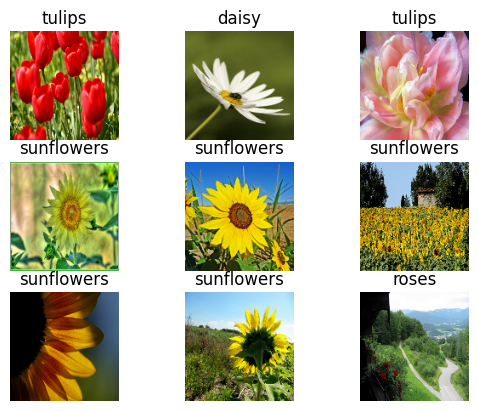

In [137]:
# prompt: show 9 images from the training set above

import matplotlib.pyplot as plt

# Take the first 9 images from the training set
for i, (image, label) in enumerate(train_ds.take(9)):
  plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(class_names[label.numpy()])
  plt.axis('off')

plt.show()

Add batch_size

In [138]:
# Add batch_size
BATCH_SIZE = 32

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [139]:
num_classes = len(class_names)

Design a model

In [140]:
# prompt: import keras from tensorflow and import layers from keras

import keras
from keras import layers
# Define the model
model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)), # Rescale input
  layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 530,709 (2.02 MB)

 Trainable params: 530,709 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

# **The number of parameters in a convolutional layer is determined by the following formula:**

```
Parameters = (Kernel Width * Kernel Height * Input Channels + 1) * Output Channels
```

Let's analyze your first convolutional layer:

`layers.Conv2D(8, (3, 3), padding='same', activation='relu')`


```
Parameters = (3 * 3 * 3 + 1) * 8 = (27 + 1) * 8 = 28 * 8 = 224
```
Another example:

`
layers.Conv2D(16, (3, 3), padding='same', activation='relu')
`

Here's how it applies to the second layer:

- Kernel Width: 3
- Kernel Height: 3
- Input Channels: 8 (This is the output from the previous layer, which had 8 filters)
- Output Channels: 16
- +1: Bias term

```
Parameters = (3 * 3 * 8 + 1) * 16 = (72 + 1) * 16 = 73 * 16 = 1168
```





Training model and calulate time for training

In [141]:
# Training model
import time
start_time = time.time()

epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60} minutes")

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 233ms/step - accuracy: 0.3163 - loss: 1.5200 - val_accuracy: 0.5264 - val_loss: 1.1786
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.5639 - loss: 1.1022 - val_accuracy: 0.5997 - val_loss: 1.0376
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.6308 - loss: 0.9395 - val_accuracy: 0.6167 - val_loss: 0.9603
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.7065 - loss: 0.8071 - val_accuracy: 0.6133 - val_loss: 0.9579
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.7589 - loss: 0.6789 - val_accuracy: 0.6031 - val_loss: 1.0615
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.7932 - loss: 0.5572 - val_accuracy: 0.6014 - val_loss: 1.1329
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.8453 - loss: 0.4295 - val_accuracy: 0.6048 - val_loss: 1.2463
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8737 - loss: 0.3703 - val_accuracy: 0.56

Visualize training results


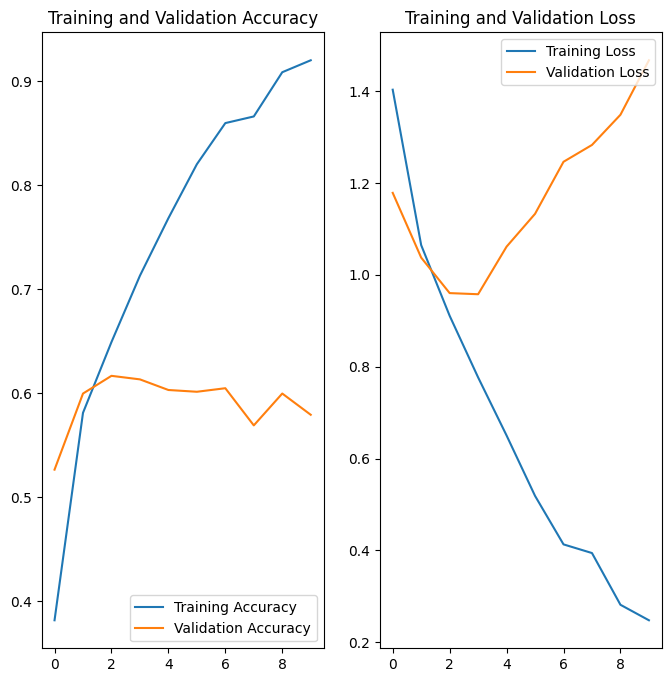

In [142]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Implement data augmentation

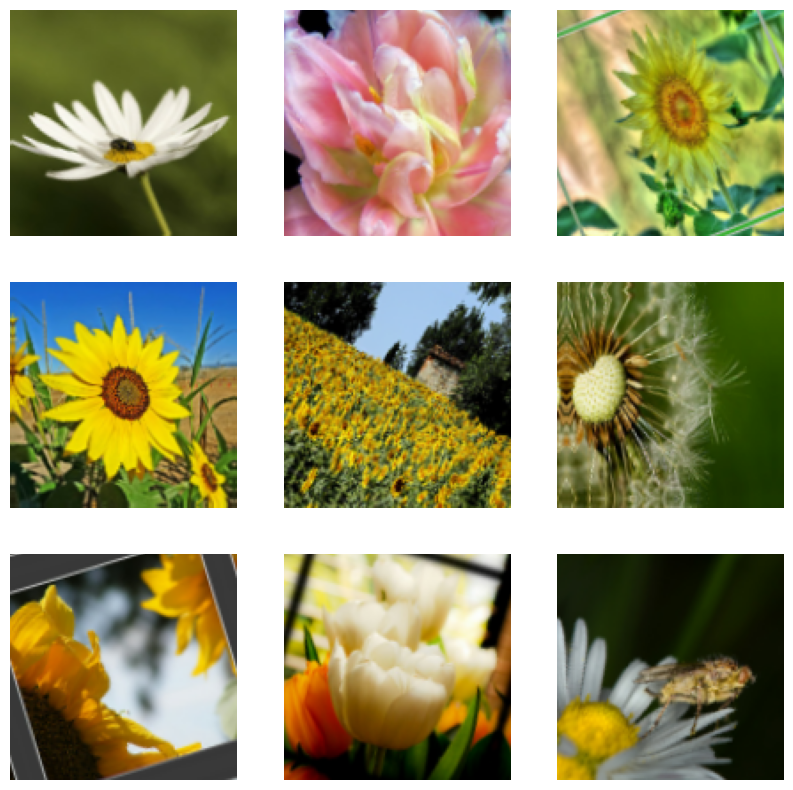

In [143]:
# Overfitting problem
# Implementation data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_SIZE,
                                   IMG_SIZE,
                                   3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Visualize a few augmented examples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")


Add data augumentation into model

In [144]:
# Define and train new model
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
  layers.MaxPool2D((2, 2)),
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  layers.MaxPool2D((2, 2)),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPool2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10
start_time = time.time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
end_time = time.time()
print(f"Training time: {(end_time - start_time)/60} minutes")

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.2846 - loss: 1.4633 - val_accuracy: 0.5281 - val_loss: 1.1551
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5216 - loss: 1.1385 - val_accuracy: 0.6014 - val_loss: 1.0163
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5952 - loss: 1.0203 - val_accuracy: 0.5860 - val_loss: 1.0494
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.6361 - loss: 0.9471 - val_accuracy: 0.6303 - val_loss: 0.9873
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6715 - loss: 0.8837 - val_accuracy: 0.6457 - val_loss: 0.9381
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.6697 - loss: 0.8436 - val_accuracy: 0.6576 - val_loss: 0.8976
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 0.6813 - loss: 0.8156 - val_accuracy: 0.6491 - val_loss: 0.9346
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.6971 - loss: 0.7824 - val_accuracy

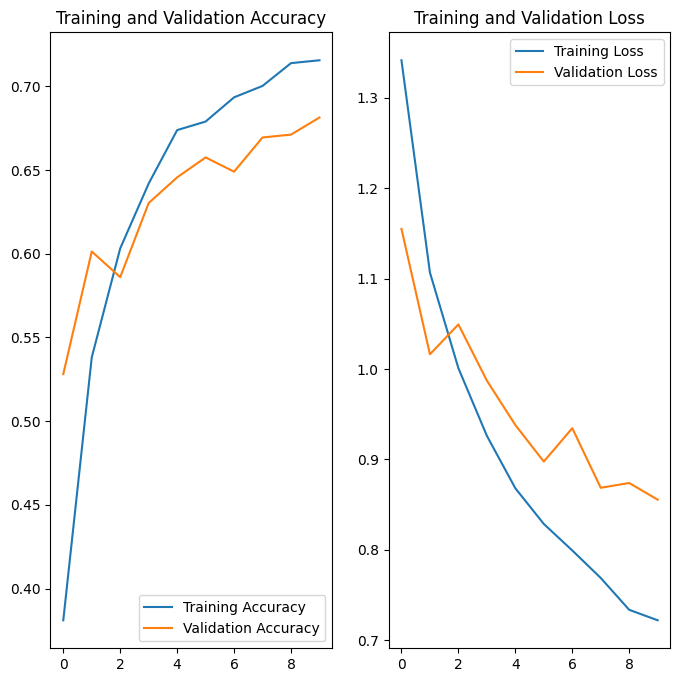

In [145]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [146]:
!pwd

/content


Save model

In [147]:
# Save model
import pathlib
model_path = pathlib.Path('/content')
model.save(os.path.join(model_path,'model.keras'))

# Load model
flower_model = tf.keras.models.load_model(os.path.join(model_path,'model.keras'))

Evaluate the model on the test set

In [148]:
# Evaluate the model
loss, accuracy = flower_model.evaluate(test_ds, verbose=1)
print(f'Test accuracy : {accuracy * 100}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.6538 - loss: 0.9305
Test accuracy : 68.93733143806458


Predict on new data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


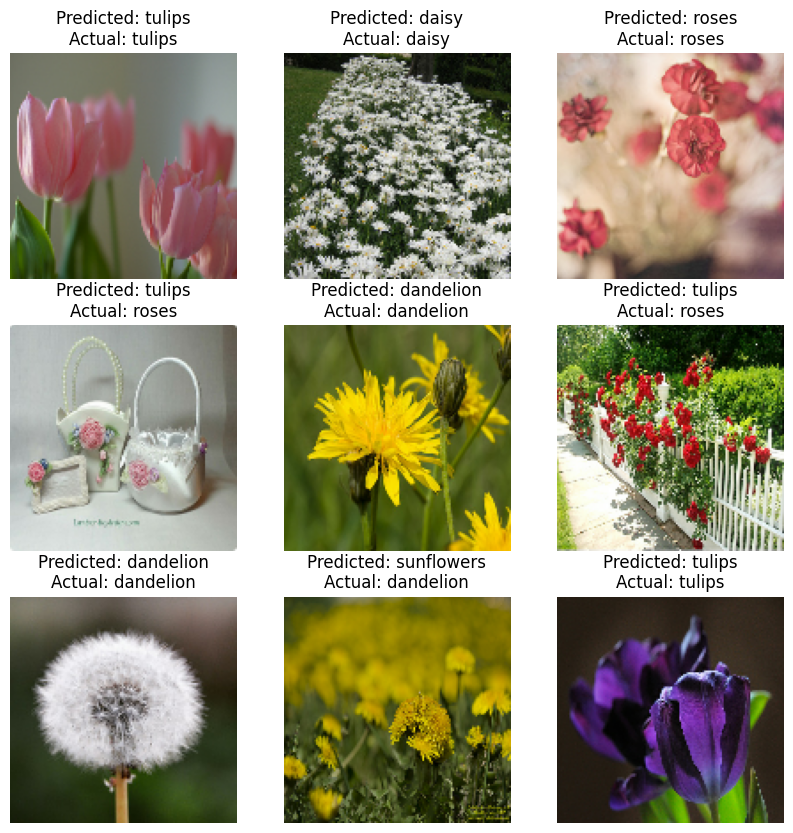

In [149]:
# prompt: show first 9 images of test_ds and predict that images belong into what classes, show in matrix 3x3

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_ds', 'class_names', and 'probability_model' are defined from the previous code.

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(test_ds.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

    # Predict the class
    predictions = flower_model.predict(np.expand_dims(image, axis=0))  # Predict for single image
    predicted_class = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class]

    plt.title(f"Predicted: {predicted_class_name}\nActual: {class_names[label.numpy()]}")

plt.show()